<a href="https://colab.research.google.com/github/jrakhshanda/Bayesian-Methods/blob/master/Topic_Modelling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install pyLDAvis

In [89]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import nltk
from nltk.corpus import wordnet

import regex as re
from nltk.stem.porter import PorterStemmer 
from nltk.tokenize import word_tokenize, sent_tokenize,RegexpTokenizer
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

import pickle
import os
from os.path import isfile, join

#for vectorizing
nltk.download('stopwords')
from nltk.stem.porter import *
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("english")

import gensim.corpora as corpora
from pprint import pprint
import gensim

import spacy

import pyLDAvis.gensim
import pickle 
import pyLDAvis

#comment this out if you're not able to view any of the print lines
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
%config InlineBackend.figure_format = 'retina'

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

#Data

In [93]:
df = pd.read_csv('/content/drive/MyDrive/data/data.zip', compression='zip', header=0)
df = df.loc[:,~df.columns.str.match("Unnamed")]
df.head()

,PMID,Title,Abstract
0,33581499,"PCNA, a focus on replication stress and the alternative lengthening of telomeres pathway.","The maintenance of telomeres, which are specialized stretches of DNA found at the ends of linear..."
1,33581339,Compositional Variability and Mutation Spectra of Monophyletic SARS-CoV-2 Clades.,COVID-19 and its causative pathogen SARS-CoV-2 have rushed the world into a staggering pandemic ...
2,33580188,Histone variant H2A.B-H2B dimers are spontaneously exchanged with canonical H2A-H2B in the nucle...,"H2A.B is an evolutionarily distant histone H2A variant that accumulates on DNA repair sites, DNA..."
3,33580181,Hypermutated phenotype in gliosarcoma of the spinal cord.,Gliosarcoma is a variant of glioblastoma with equally poor prognosis and characterized by mixed ...
4,33580144,Arsenic hexoxide has differential effects on cell proliferation and genome-wide gene expression ...,Arsenic is reportedly a biphasic inorganic compound for its toxicity and anticancer effects in h...


In [94]:
df['Text'] = df['Title'] + '. ' + df['Abstract']
df['Text'] = df['Text'].astype('str')

# Reuseable Routiens

In [95]:
def save_object(path, filename, obj):
    print('Saving Object')
    path_file = join(path, filename)    
    pickle.dump(obj, open(path_file, 'wb'))
    print('Save complete')

def load_object(path, filename):
    print('Attempting to Load Object')
    path_file = join(path, filename)    
    obj = pickle.load(open(path_file, "rb" ))
    print('Load complete')
    return obj

def save_csv(path, filename, dataframe):
    print('Saving Dataframe to CSV')
    path_file = join(path, filename)    
    dataframe.to_csv(path_file, index=False)

def load_csv(path, filename):
    print('Loading Dataframe From CSV')
    path_file = join(path, filename)
    dataframe = pd.read_csv(path_file)
    return dataframe

# Pre-processing

In [109]:
stopwords = nltk.corpus.stopwords.words('english')
newStopWords = ['type','wild','function','observed','results','different','identified','from','furthermore','process','model','effect','known','suggest','damage','human','rat','rats',
                'suggested','conclusion','determined','indicate','Moreover','system', 'form', 'treatment','disease','although','conclusion','including','exposure','repair','injury','cell',
                'functions','compared','interaction','level','demonstrated','studies','substrate','interaction','shown','contrast','presence','important', 'response','cells', 'effect','risk',
                'induction', 'increase', 'also', 'breaks','treated','showed','used','comet', 'affect', 'may', 'two','study','gene','end','ends','let','double','single','strands','stress','cross',
                'pathway','role','demonstrate','present','result','use','occur','appear','joining','affect','cause','induce','defect','induced','lead','complex','resistance','calls','ber','mutagenic','frquency',
                'analyzed','include','similar','studied','method','addition','suggesting','background','gene','expression','investigated','promote','types','dna','proteins','protein', 'ner','genomic','involved',
                'high','low','agents','using','strands','cycle','drug','investigate','increased','that','induce','structure','bindings','binding','molecular','mouse','mice','activity','sequences','factors','processes',
                'levels','level','patient','patients','dose','drug','recombination','yeast','strand','mutants','mutations','replications','homologous','genetic','genes','associative','lung', 'therapy','inhibitors',
                'specific','light','molecular','binding','sequence','lines','cancer','poly','inhibitation','activation','nuclear','regulation','tumor','mismatch','excision','base','found','containing',''
                'cellular','growth','irridation','tumors','mutations','transription','resistance','site','adducts','dose','enzyme','associated','analysis','species','tissue', 'promoter',
                'factor','domain','clinical','cancers','liver','assay','irradiated','irradiation','nucleotide','one','damage','increase','resist','mechanism','association','group','groups','aging',
                'radiation','strains','chromosome','break','sequence','mutant','however','frequency','synthesis','mutagenic','mutagenesis', 'trnscriptor','replication','dependent','mutation','genome',
                'chromosme','dependent','syndrome','radiation','effects','inhibition','genomic','chromosomal','histone','involved','process','factor','factors','effect','found','therapy']
stopwords.extend(newStopWords)

In [110]:
def preprocess(text):
  text = stemmer.stem(text) 
  tokenizer = RegexpTokenizer(r'\w+')
  words_tokens = tokenizer.tokenize(text) 
  tokens = []  
  for w in words_tokens:  
    if w not in stopwords:  
      tokens.append(w)  
  tokens = [x for x in tokens if len(x) >= 3]
  return tokens

In [111]:
tokens = [preprocess(i) for i in df['Text']]

In [112]:
save_object('/content/drive/MyDrive/models','topic_tokens',tokens)
#tokens = load_object('/content/drive/MyDrive/models','topic_tokens')

Saving Object
Save complete


# LDA model Training

In [113]:
# Create Dictionary
id2word = corpora.Dictionary(tokens)
# Create Corpus
texts = tokens
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]
# View
print(corpus[:1][0][:30])

[(0, 1), (1, 5), (2, 2), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1)]


In [114]:
# number of topics
num_topics = 8
# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=num_topics)
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]


Streaming output truncated to the last 5000 lines.
/usr/local/lib/python3.6/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.6/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.6/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt

[(0,
  '0.006*"transcription" + 0.004*"instability" + 0.004*"show" + 0.004*"nhej" + '
  '0.004*"helicase" + 0.003*"pathways" + 0.003*"deficient" + 0.003*"mediated" '
  '+ 0.002*"mechanisms" + 0.002*"required"'),
 (1,
  '0.007*"polymorphisms" + 0.005*"xrcc1" + 0.004*"based" + '
  '0.004*"chemotherapy" + 0.004*"polymorphism" + 0.004*"cisplatin" + '
  '0.004*"significant" + 0.004*"ercc1" + 0.003*"genotype" + 0.003*"platinum"'),
 (2,
  '0.005*"apoptosis" + 0.005*"parp" + 0.004*"survival" + 0.004*"gamma" + '
  '0.003*"significantly" + 0.003*"vitro" + 0.003*"adp" + 0.003*"sensitivity" + '
  '0.003*"line" + 0.003*"time"'),
 (3,
  '0.005*"reca" + 0.005*"sos" + 0.004*"beta" + 0.004*"coli" + 0.004*"strain" + '
  '0.003*"exposed" + 0.003*"oxidative" + 0.003*"rate" + 0.003*"escherichia" + '
  '0.003*"related"'),
 (4,
  '0.006*"brca1" + 0.006*"rad51" + 0.006*"atm" + 0.005*"pcna" + 0.004*"dsb" + '
  '0.004*"kinase" + 0.004*"polymerase" + 0.004*"show" + 0.004*"checkpoint" + '
  '0.004*"cerevisiae"'),

In [115]:
pprint(lda_model.print_topics())

[(0,
  '0.006*"transcription" + 0.004*"instability" + 0.004*"show" + 0.004*"nhej" + '
  '0.004*"helicase" + 0.003*"pathways" + 0.003*"deficient" + 0.003*"mediated" '
  '+ 0.002*"mechanisms" + 0.002*"required"'),
 (1,
  '0.007*"polymorphisms" + 0.005*"xrcc1" + 0.004*"based" + '
  '0.004*"chemotherapy" + 0.004*"polymorphism" + 0.004*"cisplatin" + '
  '0.004*"significant" + 0.004*"ercc1" + 0.003*"genotype" + 0.003*"platinum"'),
 (2,
  '0.005*"apoptosis" + 0.005*"parp" + 0.004*"survival" + 0.004*"gamma" + '
  '0.003*"significantly" + 0.003*"vitro" + 0.003*"adp" + 0.003*"sensitivity" + '
  '0.003*"line" + 0.003*"time"'),
 (3,
  '0.005*"reca" + 0.005*"sos" + 0.004*"beta" + 0.004*"coli" + 0.004*"strain" + '
  '0.003*"exposed" + 0.003*"oxidative" + 0.003*"rate" + 0.003*"escherichia" + '
  '0.003*"related"'),
 (4,
  '0.006*"brca1" + 0.006*"rad51" + 0.006*"atm" + 0.005*"pcna" + 0.004*"dsb" + '
  '0.004*"kinase" + 0.004*"polymerase" + 0.004*"show" + 0.004*"checkpoint" + '
  '0.004*"cerevisiae"'),

## Analysis of Results

### What is the Dominant topic and its percentage contribution in each document?
In LDA models, each document is composed of multiple topics. But, typically only one of the topics is dominant. The below code extracts this dominant topic for each sentence and shows the weight of the topic and the keywords in a nicely formatted output.

This way, you will know which document belongs predominantly to which topic.

In [116]:
def format_topics_sentences(ldamodel=None, corpus = corpus, texts= texts):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return sent_topics_df


In [117]:
df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=texts)

In [118]:
# Format
df_dominant = df_topic_sents_keywords.reset_index()
df_dominant.columns = ['PMID', 'Dominant Topic', 'Topic % Contribution', 'Keywords', 'Text']
df_dominant['PMID'] = df['PMID']
df_dominant.head(8)

,PMID,Dominant Topic,Topic % Contribution,Keywords,Text
0,33581499,1.0,0.4237,"polymorphisms, xrcc1, based, chemotherapy, polymorphism, cisplatin, significant, ercc1, genotype...","[pcna, focus, alternative, lengthening, telomeres, maintenance, telomeres, specialized, stretche..."
1,33581339,7.0,0.4864,"coli, escherichia, plasmid, vitro, polymerase, mechanisms, vivo, stranded, new, rna","[compositional, variability, spectra, monophyletic, sars, cov, clades, covid, causative, pathoge..."
2,33580188,6.0,0.9906,"p53, chromatin, skin, glycosylase, sites, beta, lesions, transcription, damaged, endonuclease","[variant, h2a, h2b, dimers, spontaneously, exchanged, canonical, h2a, h2b, nucleosome, h2a, evol..."
3,33580181,5.0,0.6831,"colorectal, mmr, msi, instability, microsatellite, cases, msh2, mlh1, hnpcc, hereditary","[hypermutated, phenotype, gliosarcoma, spinal, cord, gliosarcoma, variant, glioblastoma, equally..."
4,33580144,2.0,0.8458,"apoptosis, parp, survival, gamma, significantly, vitro, adp, sensitivity, line, time","[arsenic, hexoxide, differential, proliferation, wide, primary, mammary, epithelial, mcf7, arsen..."
5,33579976,0.0,0.3552,"transcription, instability, show, nhej, helicase, pathways, deficient, mediated, mechanisms, req...","[persistent, stag2, despite, multimodal, recurrent, pediatric, glioblastoma, adult, counterparts..."
6,33579974,5.0,0.8631,"colorectal, mmr, msi, instability, microsatellite, cases, msh2, mlh1, hnpcc, hereditary","[somatic, aberrations, benign, breast, subsequent, breast, largely, unknown, development, breast..."
7,33579938,5.0,0.9905,"colorectal, mmr, msi, instability, microsatellite, cases, msh2, mlh1, hnpcc, hereditary","[whole, sequencing, data, derive, deficiency, scores, deficiency, hrd, score, developed, whole, ..."


In [119]:
save_csv('/content/drive/MyDrive/data','dominant_topics_',df_dominant)
#df_dominant = load_csv('/content/drive/MyDrive/data','dominant_topics')
pd.options.display.max_colwidth = 100

Saving Dataframe to CSV


### Frequency Distribution of Word Counts in Documents

When working with a large number of documents, you want to know how big the documents are as a whole and by topic. Let’s plot the document word counts distribution.

<Figure size 1296x576 with 0 Axes>

(array([  2.,   0.,   0.,   1.,   5.,   3.,   3.,   8.,   4.,   8.,   7.,
          6.,   9.,  10.,  15.,   9.,  16.,  14.,  20.,  20.,  22.,  22.,
         28.,  36.,  41.,  44.,  45.,  37.,  48.,  56.,  53.,  59.,  49.,
         70.,  77.,  71.,  79.,  77.,  80.,  78.,  98.,  96.,  94.,  90.,
        131., 121., 131., 141., 137., 139., 140., 181., 181., 170., 185.,
        172., 176., 222., 208., 232., 269., 262., 274., 304., 286., 289.,
        321., 325., 379., 335., 369., 384., 400., 405., 396., 394., 463.,
        483., 498., 466., 481., 504., 522., 561., 576., 574., 642., 611.,
        633., 625., 614., 668., 693., 647., 647., 681., 704., 762., 777.,
        824., 859., 849., 822., 868., 774., 838., 912., 853., 849., 916.,
        950., 873., 916., 823., 943., 983., 983., 978., 954., 925., 955.,
        938., 948., 877., 927., 966., 986., 922., 927., 911., 888., 846.,
        821., 907., 895., 953., 970., 903., 891., 880., 876., 928., 848.,
        839., 850., 866., 841., 832., 

Text(2000, 900, 'Mean   : 1200')

Text(2000, 850, 'Median : 1177')

Text(2000, 800, 'Stdev   : 401')

Text(2000, 750, '1% quantile    : 369')

Text(2000, 700, '99% quantile  : 2323')

[Text(0, 0.5, 'Number of Documents'),
 (0.0, 2500.0),
 Text(0.5, 0, 'Document Word Count')]

([<matplotlib.axis.XTick at 0x7fd65e439da0>,
 <a list of 9 Text major ticklabel objects>)

Text(0.5, 1.0, 'Distribution of Document Word Counts')

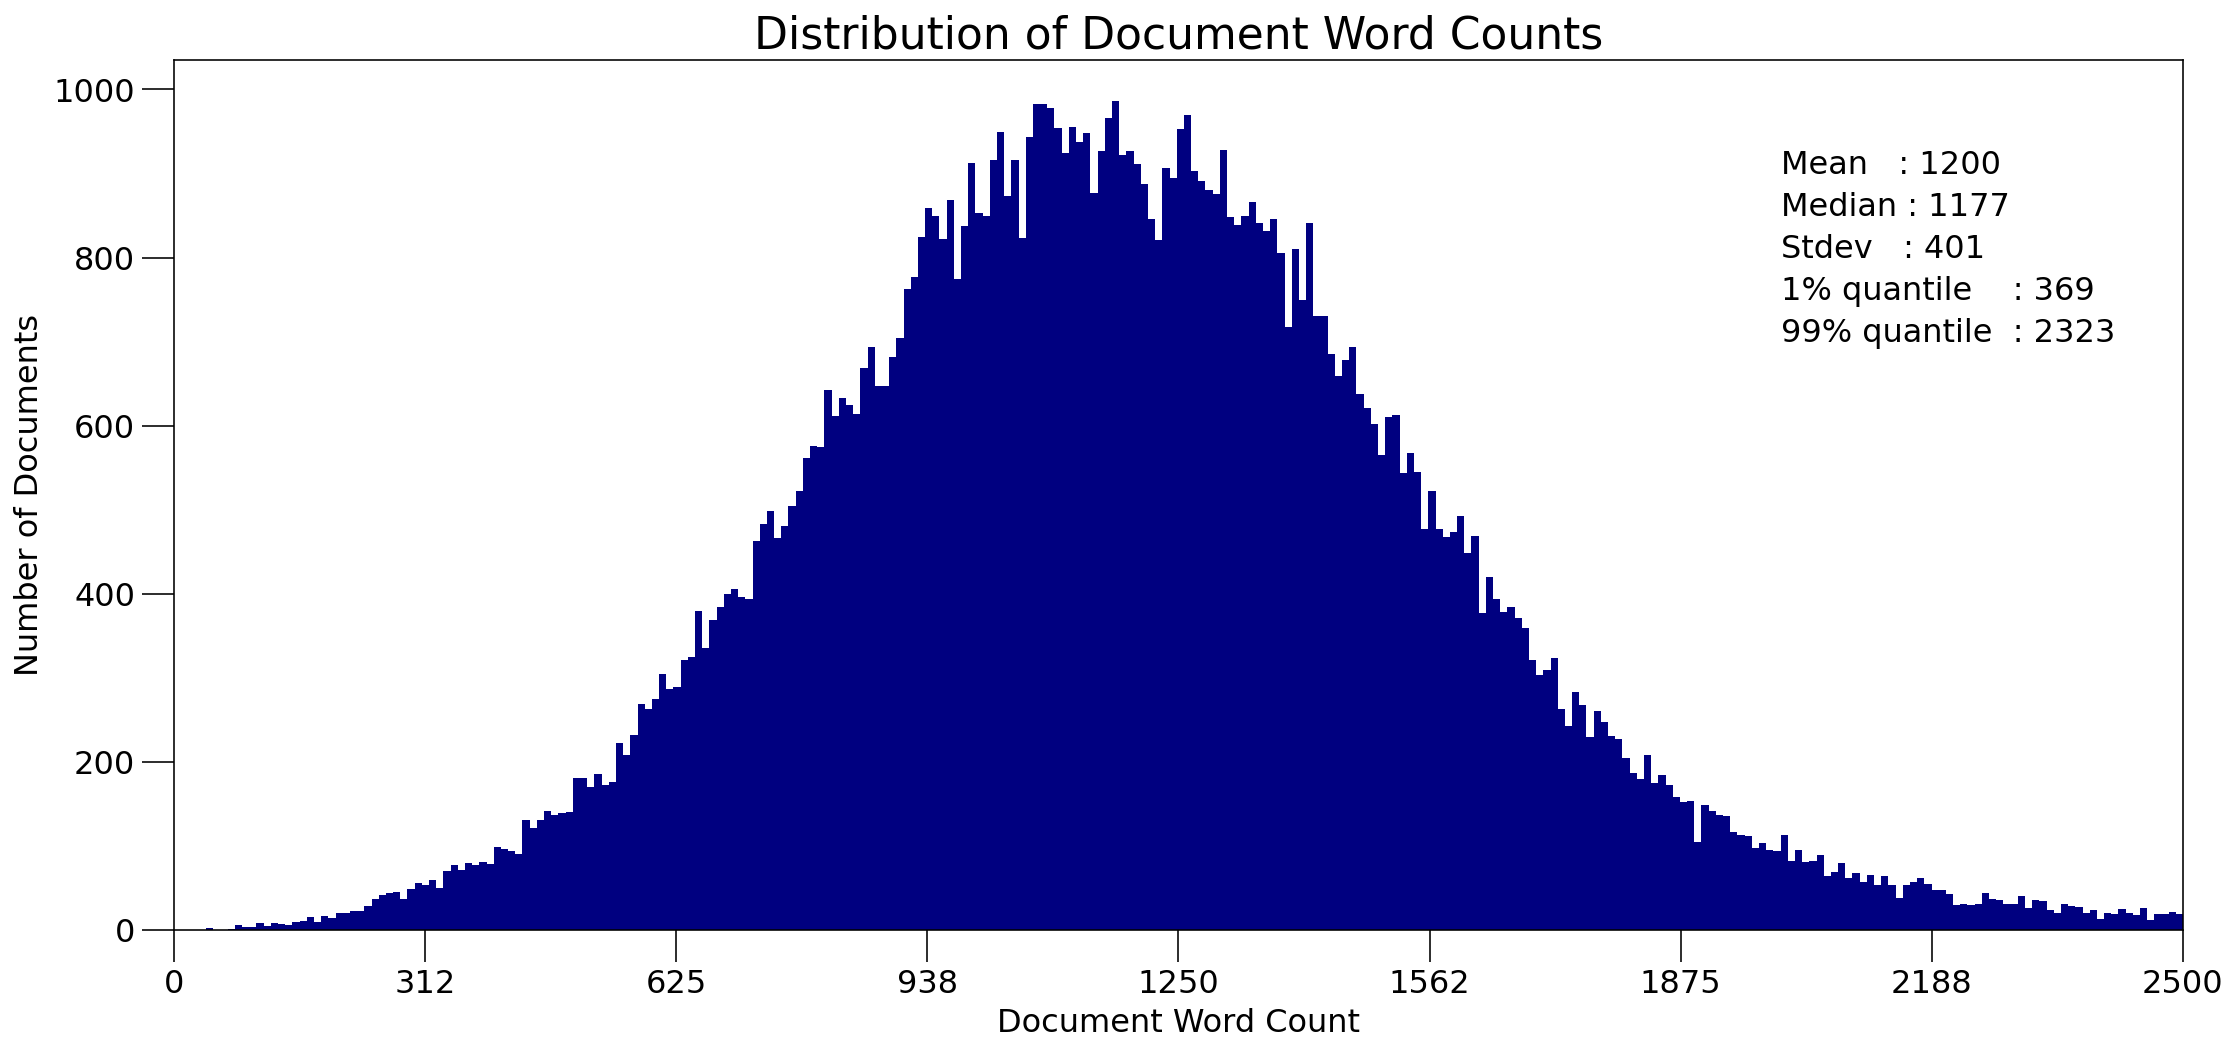

In [56]:
doc_lens = [len(d) for d in df_dominant.Text]

# Plot
plt.figure(figsize=(18,8))
plt.rcParams.update({'font.size': 16})
# plt.figure(figsize=(16,7), dpi=160)
plt.hist(doc_lens, bins = 1000, color='navy')
plt.text(2000, 900, "Mean   : " + str(round(np.mean(doc_lens))))
plt.text(2000,  850, "Median : " + str(round(np.median(doc_lens))))
plt.text(2000,  800, "Stdev   : " + str(round(np.std(doc_lens))))
plt.text(2000,  750, "1% quantile    : " + str(round(np.quantile(doc_lens, q=0.01))))
plt.text(2000,  700, "99% quantile  : " + str(round(np.quantile(doc_lens, q=0.99))))

plt.gca().set(xlim=(0, 2500), ylabel='Number of Documents', xlabel='Document Word Count')
plt.tick_params(size=16)
plt.xticks(np.linspace(0,2500,9))
plt.title('Distribution of Document Word Counts', fontdict=dict(size=22))
plt.savefig('/content/drive/MyDrive/plots/distribution_word_counts.png')

(array([ 3.,  0.,  1.,  1.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,
         1.,  1.,  1.,  0.,  0.,  0.,  2.,  3.,  0.,  0.,  2.,  0.,  2.,
         1.,  1.,  2.,  1.,  0.,  0.,  1.,  1.,  0.,  1.,  2.,  1.,  3.,
         1.,  2.,  3.,  2.,  2.,  2.,  2.,  1.,  4.,  4.,  2.,  0.,  2.,
         2.,  6.,  6.,  5.,  3.,  7.,  7.,  4.,  6.,  8.,  1.,  2.,  7.,
         5.,  7.,  4.,  9.,  7.,  7., 11.,  8.,  8., 11.,  3.,  6.,  9.,
         3., 11.,  9., 13.,  7., 11., 10.,  8., 13., 11.,  3., 14.,  7.,
         8.,  6., 19., 21., 12.,  9., 13., 11., 18., 17., 13., 16., 18.,
         9., 21., 11., 20., 22., 21., 21., 21., 14., 24., 23., 20., 17.,
        20., 26., 23., 13., 26., 18., 22., 17., 16., 30., 18., 33., 27.,
        17., 32., 27., 27., 26., 26., 25., 30., 30., 34., 35., 30., 32.,
        31., 26., 28., 28., 37., 32., 42., 28., 29., 36., 31., 29., 34.,
        38., 46., 27., 26., 47., 35., 35., 35., 38., 46., 42., 49., 51.,
        47., 41., 53., 42., 47., 34., 51., 47., 43.

[(0.0, 2200.0), Text(0.5, 0, 'Document Word Count')]

Text(0, 0.5, 'Number of Documents')

Text(0.5, 1.0, 'Topic: 0')

(array([ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  1.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  1.,  0.,  0.,
         1.,  0.,  1.,  2.,  1.,  2.,  2.,  1.,  1.,  2.,  2.,  0.,  2.,
         1.,  2.,  1.,  1.,  0.,  3.,  0.,  2.,  0.,  1.,  3.,  4.,  3.,
         2.,  0.,  6.,  5.,  1.,  4.,  3.,  1.,  7.,  3.,  6.,  3.,  4.,
         6.,  5.,  1.,  3.,  4.,  5.,  6.,  1.,  3.,  4.,  7.,  5.,  3.,
         8.,  4.,  3.,  7.,  1., 10.,  4.,  4.,  9., 10.,  9.,  5.,  6.,
         8., 11., 12.,  8., 13., 18.,  7.,  9., 11.,  9.,  6., 14., 13.,
         7., 10., 15., 16.,  9., 16., 10., 17., 16.,  6., 12.,  8.,  9.,
         9., 14.,  9., 14., 16., 22., 17., 17., 15., 14., 20., 18., 19.,
        21., 16., 16., 30., 23., 21., 19., 20., 27., 19., 25., 22., 22.,
        30., 33., 31., 27., 30., 23., 30., 22., 29., 34., 26., 30., 28.,
        35., 24., 34., 45., 35., 23., 29., 39., 30.

[(0.0, 2200.0), Text(0.5, 0, 'Document Word Count')]

Text(0, 0.5, 'Number of Documents')

Text(0.5, 1.0, 'Topic: 1')

(array([  1.,   0.,   0.,   0.,   0.,   1.,   1.,   0.,   0.,   0.,   1.,
          0.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,   1.,   1.,   1.,
          3.,   1.,   2.,   0.,   2.,   3.,   1.,   4.,   0.,   2.,   0.,
          2.,   1.,   4.,   2.,   2.,   3.,   1.,   2.,   2.,   3.,   5.,
          0.,   1.,   5.,   5.,   3.,   8.,   2.,   0.,   6.,   3.,   9.,
          2.,  11.,   6.,   3.,   5.,   5.,   8.,  10.,   9.,  10.,   6.,
          8.,   7.,   5.,   6.,   8.,   7.,   5.,  11.,  10.,   9.,   8.,
          8.,   7.,  11.,  12.,  10.,  11.,  13.,  21.,  18.,  20.,   9.,
         19.,  21.,  11.,  18.,  15.,  15.,  17.,  20.,  17.,  19.,  22.,
         21.,  21.,  30.,  19.,  18.,  18.,  40.,  31.,  25.,  18.,  29.,
         30.,  26.,  31.,  34.,  25.,  27.,  26.,  20.,  34.,  31.,  30.,
         33.,  35.,  29.,  42.,  33.,  34.,  43.,  41.,  34.,  37.,  41.,
         46.,  35.,  37.,  48.,  39.,  39.,  48.,  42.,  37.,  47.,  47.,
         54.,  54.,  44.,  45.,  57., 

[(0.0, 2200.0), Text(0.5, 0, 'Document Word Count')]

Text(0, 0.5, 'Number of Documents')

Text(0.5, 1.0, 'Topic: 2')

(array([  1.,   0.,   1.,   1.,   0.,   2.,   2.,   1.,   3.,   3.,   1.,
          2.,   1.,   1.,   2.,   4.,   1.,   5.,   2.,   0.,   2.,   1.,
          2.,   5.,   3.,   3.,   5.,   6.,   2.,  10.,  10.,   5.,  15.,
         10.,   6.,   8.,   5.,  14.,   9.,   5.,   6.,  14.,   6.,  15.,
         10.,  11.,  11.,  12.,   7.,  18.,  18.,   5.,  13.,  19.,  14.,
         12.,  10.,  10.,  23.,  14.,  15.,  18.,  16.,  16.,  17.,  22.,
         18.,  25.,  27.,  22.,  21.,  23.,  27.,  19.,  23.,  27.,  26.,
         33.,  22.,  22.,  30.,  21.,  32.,  25.,  31.,  28.,  28.,  25.,
         32.,  31.,  44.,  42.,  48.,  42.,  43.,  43.,  40.,  32.,  38.,
         45.,  49.,  34.,  43.,  57.,  43.,  49.,  51.,  51.,  68.,  44.,
         53.,  59.,  58.,  71.,  72.,  58.,  71.,  67.,  70.,  58.,  70.,
         56.,  70.,  72.,  49.,  81.,  74.,  60.,  88.,  68.,  83.,  82.,
         63.,  83.,  80.,  66.,  97., 100.,  74.,  76.,  83.,  74.,  81.,
         95.,  70., 100.,  82.,  83., 

[(0.0, 2200.0), Text(0.5, 0, 'Document Word Count')]

Text(0, 0.5, 'Number of Documents')

Text(0.5, 1.0, 'Topic: 3')

(array([ 1.,  0.,  1.,  0.,  1.,  1.,  0.,  0.,  1.,  0.,  1.,  1.,  0.,
         0.,  0.,  0.,  2.,  2.,  1.,  1.,  2.,  2.,  2.,  3.,  3.,  1.,
         2.,  3.,  1.,  0.,  2.,  2.,  4.,  3.,  1.,  1.,  3.,  2.,  6.,
         4.,  2.,  4.,  0.,  3.,  3.,  3.,  5.,  3.,  9.,  7.,  4.,  5.,
         1.,  8.,  3.,  6.,  0.,  3.,  7.,  1.,  8.,  4.,  5.,  1.,  6.,
         3., 11.,  3.,  6.,  3.,  2.,  8.,  3.,  7.,  6.,  5.,  6.,  5.,
        10.,  8.,  4.,  4.,  7.,  6., 10.,  8., 14., 12.,  8., 10.,  6.,
        11., 11.,  5., 12.,  8., 11.,  8.,  8., 11., 14., 10., 15.,  9.,
         8., 10., 16., 11., 16., 17., 17., 18., 15., 12., 12., 13., 13.,
        17., 18., 16., 26., 16., 15., 18., 15., 21., 11., 26., 15., 39.,
        16., 17., 26., 16., 28., 21., 33., 17., 27., 21., 25., 17., 16.,
        32., 25., 24., 28., 29., 33., 46., 29., 28., 23., 18., 31., 30.,
        40., 30., 41., 27., 31., 45., 29., 42., 28., 45., 27., 43., 35.,
        44., 39., 29., 52., 39., 45., 41., 41., 27.

[(0.0, 2200.0), Text(0.5, 0, 'Document Word Count')]

Text(0, 0.5, 'Number of Documents')

Text(0.5, 1.0, 'Topic: 4')

(array([  2.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,   2.,   1.,
          2.,   2.,   1.,   2.,   2.,   3.,   2.,   1.,   6.,   1.,   2.,
          7.,   4.,   3.,   4.,   6.,   4.,  10.,  11.,   6.,   5.,   7.,
          8.,   7.,  13.,   6.,   9.,   9.,  15.,  16.,  10.,  11.,   9.,
         15.,  14.,  12.,  15.,  15.,  25.,  17.,  20.,  19.,  21.,  19.,
         15.,  26.,  17.,  28.,  19.,  24.,  30.,  29.,  34.,  27.,  37.,
         26.,  41.,  18.,  38.,  35.,  45.,  48.,  34.,  46.,  46.,  46.,
         40.,  62.,  60.,  52.,  59.,  42.,  53.,  49.,  50.,  59.,  61.,
         50.,  65.,  68.,  62.,  50.,  81.,  80.,  68.,  59.,  82.,  76.,
         79.,  78.,  78.,  78.,  91.,  91.,  88.,  83.,  69., 100.,  81.,
         97.,  74.,  96.,  75., 113., 100.,  88.,  92., 109., 100., 102.,
        105.,  91.,  84.,  97.,  95., 107.,  80.,  77., 102.,  96.,  97.,
        118.,  84., 107., 116.,  95., 110.,  95.,  95., 102.,  91., 102.,
        100., 101.,  94., 105., 114., 

[(0.0, 2200.0), Text(0.5, 0, 'Document Word Count')]

Text(0, 0.5, 'Number of Documents')

Text(0.5, 1.0, 'Topic: 5')

(array([ 1.,  0.,  2.,  1.,  1.,  0.,  1.,  1.,  0.,  1.,  2.,  0.,  1.,
         4.,  0.,  1.,  0.,  1.,  0.,  2.,  0.,  1.,  1.,  1.,  1.,  0.,
         6.,  3.,  1.,  2.,  2.,  1.,  1.,  1.,  1.,  4.,  3.,  3.,  4.,
         5.,  1.,  2.,  0.,  4.,  5.,  1.,  4.,  3.,  3.,  2.,  4.,  1.,
         3.,  4.,  7.,  8.,  7.,  3.,  4.,  4.,  6.,  5.,  5.,  3., 12.,
         8.,  7.,  7.,  6.,  5.,  3.,  9.,  9.,  5., 15., 11., 12.,  8.,
         8., 12., 11.,  9., 14.,  6., 16., 12., 17., 15., 16., 10., 16.,
        18., 20., 22., 16., 22., 16., 17.,  9., 19., 20., 16., 24., 29.,
        23., 23., 22., 23., 32., 29., 23., 31., 31., 24., 36., 29., 28.,
        31., 33., 25., 34., 33., 35., 20., 30., 28., 37., 38., 30., 41.,
        35., 37., 49., 44., 43., 43., 44., 36., 56., 36., 42., 38., 44.,
        60., 57., 47., 40., 57., 47., 53., 60., 44., 56., 57., 43., 47.,
        66., 48., 52., 54., 58., 68., 61., 61., 63., 54., 73., 70., 60.,
        46., 58., 46., 66., 61., 56., 58., 71., 54.

[(0.0, 2200.0), Text(0.5, 0, 'Document Word Count')]

Text(0, 0.5, 'Number of Documents')

Text(0.5, 1.0, 'Topic: 6')

(array([ 1.,  0.,  0.,  0.,  1.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  2.,
         1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,
         0.,  0.,  2.,  1.,  1.,  0.,  0.,  0.,  0.,  1.,  1.,  1.,  0.,
         2.,  1.,  0.,  2.,  1.,  0.,  0.,  0.,  0.,  1.,  0.,  2.,  2.,
         3.,  4.,  1.,  2.,  0.,  2.,  1.,  2.,  1.,  2.,  5.,  3.,  2.,
         1.,  2.,  1.,  3.,  1.,  3.,  4.,  0.,  5.,  1.,  3.,  5.,  8.,
         2.,  1.,  2.,  4.,  2.,  2.,  0.,  3.,  4.,  4.,  3.,  4.,  3.,
         2.,  3.,  3.,  1.,  1.,  3.,  5.,  3.,  7.,  7.,  4.,  5.,  4.,
         2.,  3.,  1.,  2.,  2.,  3.,  4.,  1.,  4.,  6.,  4.,  3.,  9.,
         7., 10.,  6.,  4.,  6.,  6.,  9.,  2.,  4.,  8.,  5.,  6.,  3.,
         3.,  6., 10.,  6.,  3.,  5.,  5.,  6., 11., 13.,  7.,  7., 10.,
         3.,  4., 11.,  5.,  7.,  6.,  6.,  3.,  7., 11.,  9., 12., 13.,
         8., 11., 10.,  5.,  9.,  6., 17., 10., 10., 15., 17.,  5.,  9.,
        13.,  8., 15., 18.,  9., 15., 17., 12., 11.

[(0.0, 2200.0), Text(0.5, 0, 'Document Word Count')]

Text(0, 0.5, 'Number of Documents')

Text(0.5, 1.0, 'Topic: 7')

(array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 

[(0.0, 2200.0), Text(0.5, 0, 'Document Word Count')]

Text(0, 0.5, 'Number of Documents')

Text(0.5, 1.0, 'Topic: 8')

Text(0.5, 0.98, 'Distribution of Document Word Counts by Dominant Topic')

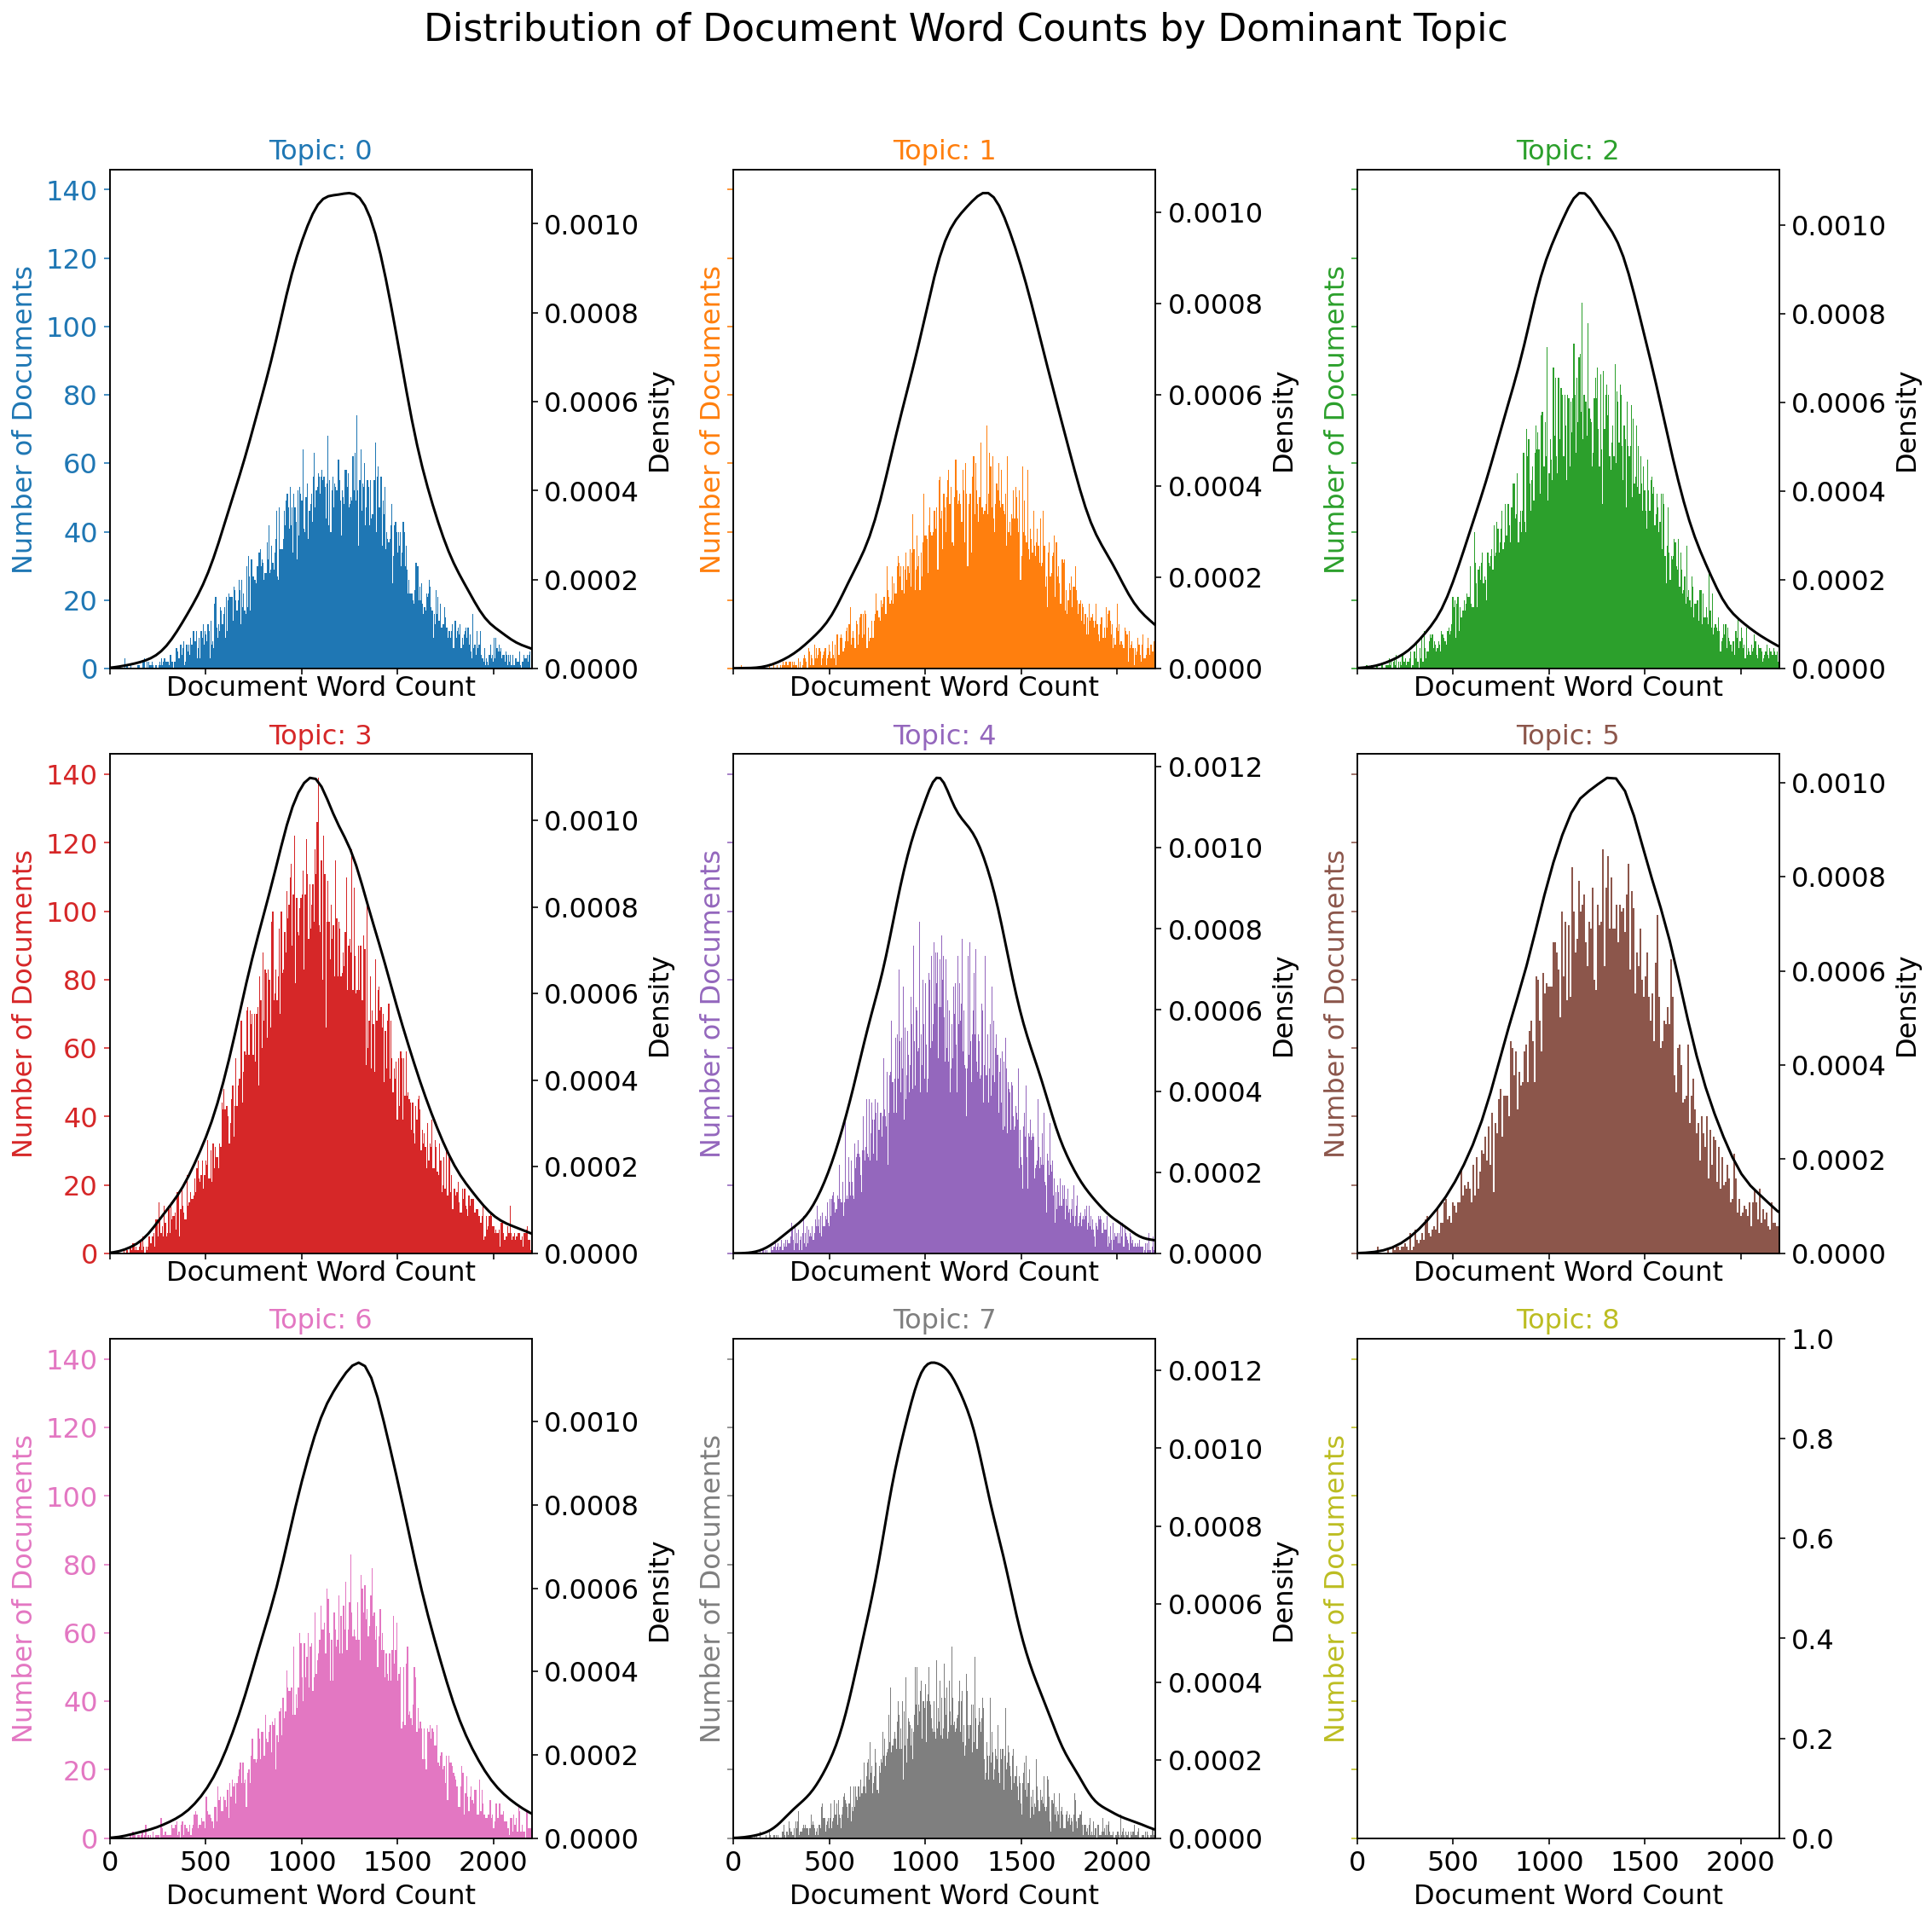

In [64]:
import seaborn as sns
import matplotlib.colors as mcolors
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

fig, axes = plt.subplots(2,3,figsize=(20,16), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):    
    df_dominant_sub = df_dominant.loc[df_dominant['Dominant Topic'] == i, :]
    doc_lens = [len(d) for d in df_dominant_sub.Text]
    ax.hist(doc_lens, bins = 1000, color=cols[i])
    ax.tick_params(axis='y', labelcolor=cols[i], color=cols[i])
    sns.kdeplot(doc_lens, color="black", shade=False, ax=ax.twinx())
    ax.set(xlim=(0, 2200), xlabel='Document Word Count')
    ax.set_ylabel('Number of Documents', color=cols[i])
    ax.set_title('Topic: '+str(i), fontdict=dict(size=16, color=cols[i]))

fig.tight_layout()
fig.subplots_adjust(top=0.90)
#plt.xticks(np.linspace(0,1000,9))
fig.suptitle('Distribution of Document Word Counts by Dominant Topic', fontsize=22)
plt.savefig('/content/drive/MyDrive/plots/distribution_word_topic.png')
plt.show()

### Word Clouds of Top N Keywords in Each Topic

Text(0.5, 1.0, 'Topic 0')

(-0.5, 2499.5, 1799.5, -0.5)

Text(0.5, 1.0, 'Topic 1')

(-0.5, 2499.5, 1799.5, -0.5)

Text(0.5, 1.0, 'Topic 2')

(-0.5, 2499.5, 1799.5, -0.5)

Text(0.5, 1.0, 'Topic 3')

(-0.5, 2499.5, 1799.5, -0.5)

Text(0.5, 1.0, 'Topic 4')

(-0.5, 2499.5, 1799.5, -0.5)

Text(0.5, 1.0, 'Topic 5')

(-0.5, 2499.5, 1799.5, -0.5)

Text(0.5, 1.0, 'Topic 6')

(-0.5, 2499.5, 1799.5, -0.5)

Text(0.5, 1.0, 'Topic 7')

(-0.5, 2499.5, 1799.5, -0.5)

(-0.5, 2499.5, 1799.5, -0.5)

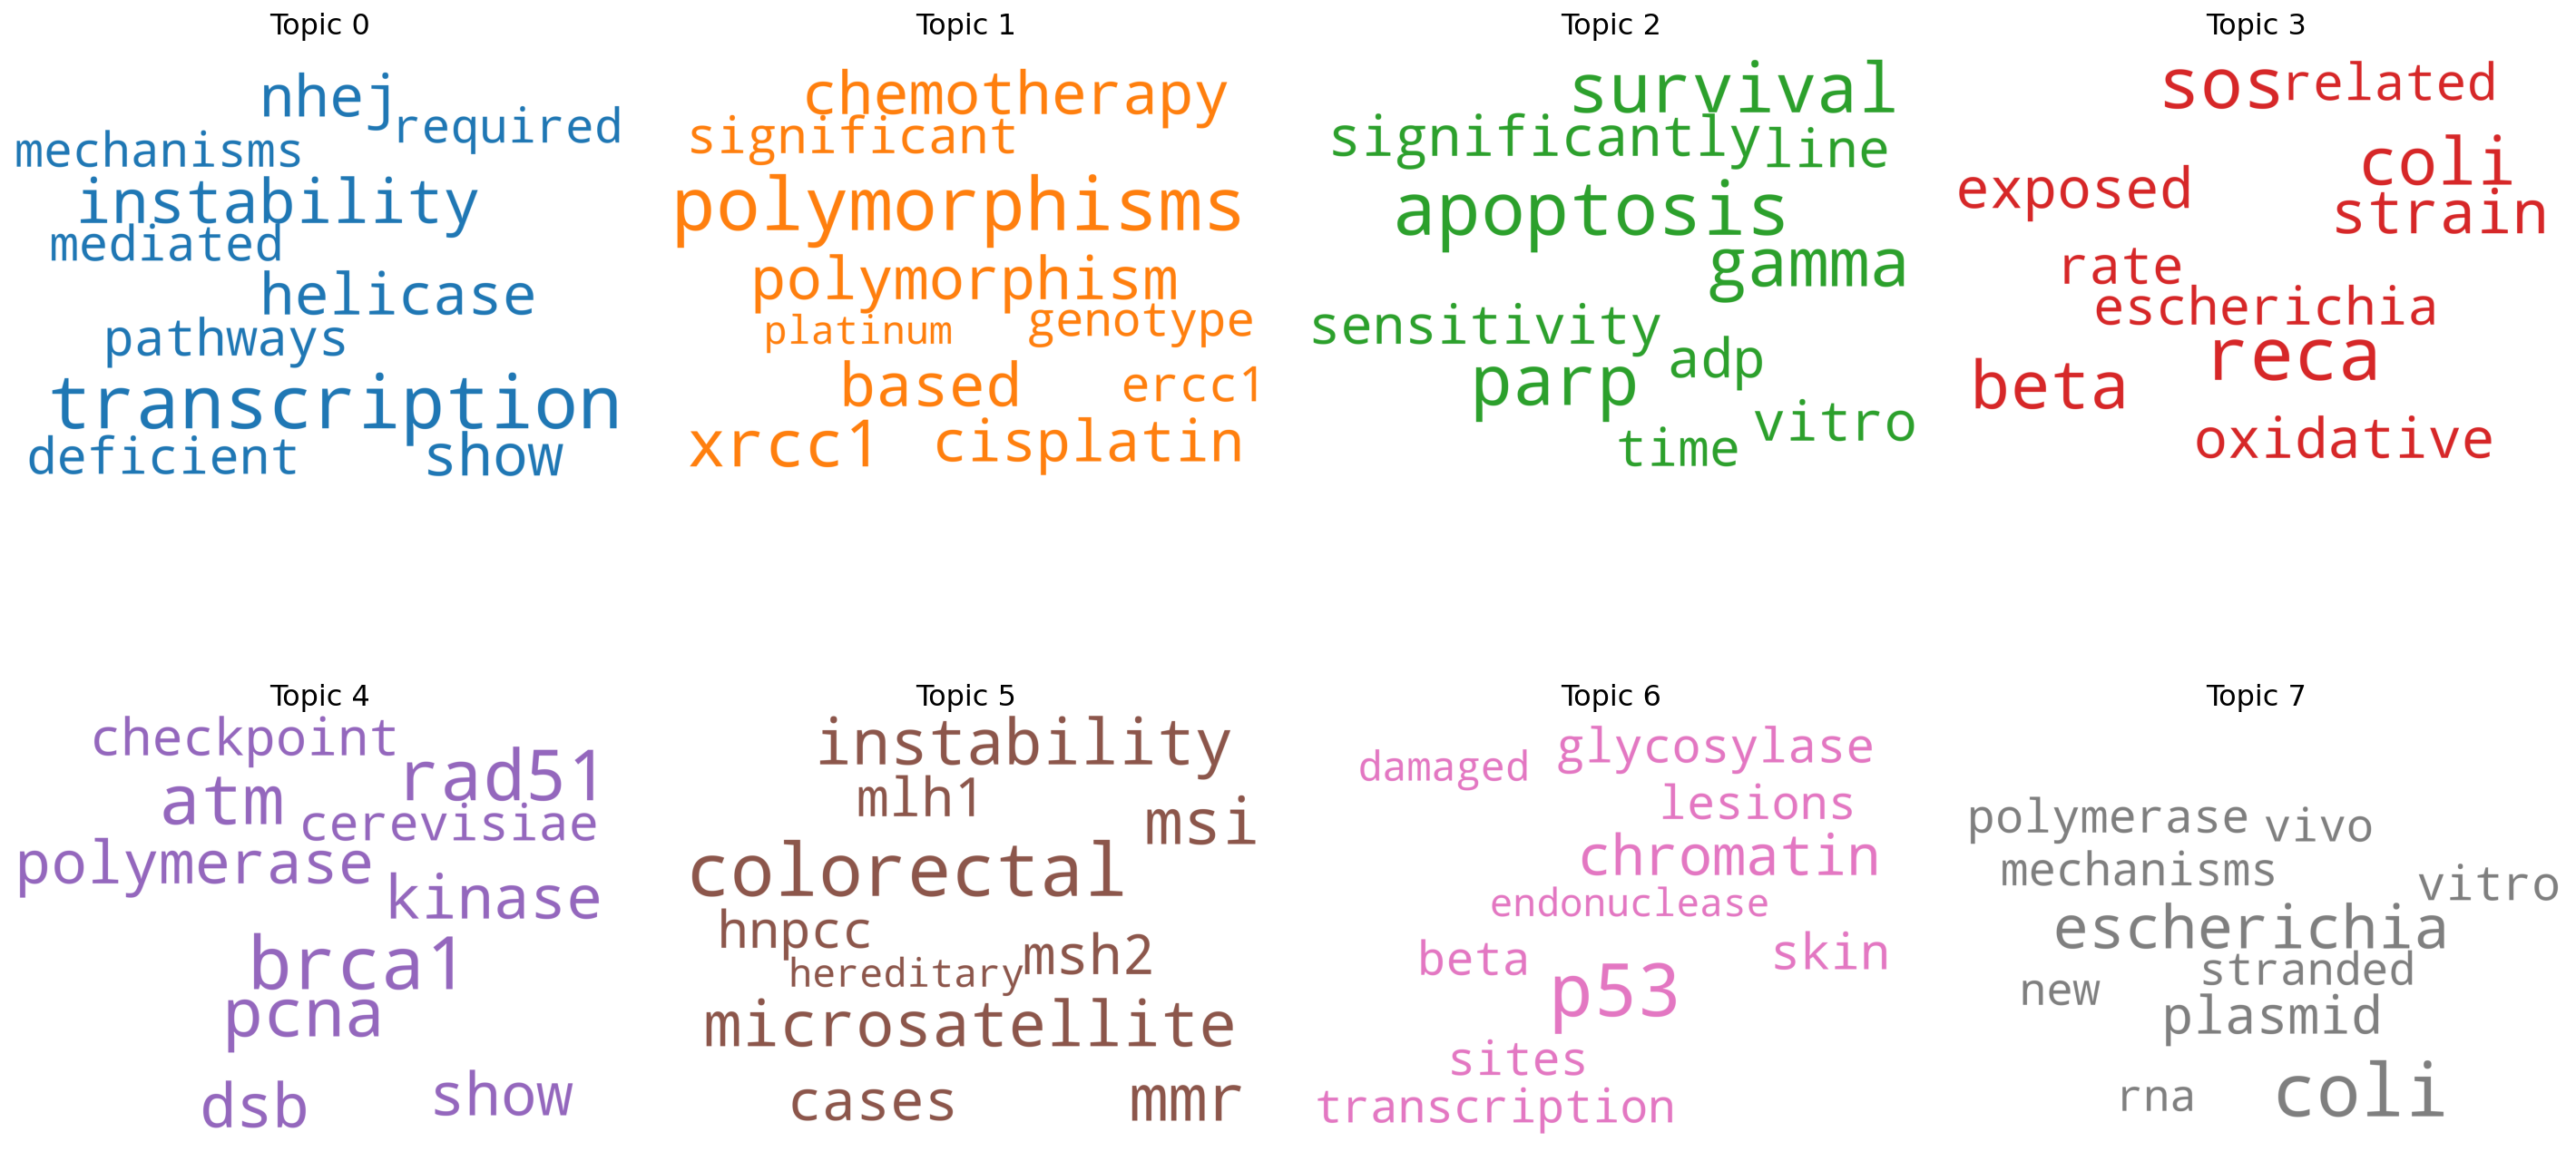

In [120]:
### # 1. Wordcloud of Top N words in each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cloud_stopwords = ['radiation','strains','chromosome','break','sequence','mutant','however','frequency','synthesis','mutagenic','mutagenesis',
                   'trnscriptor','replication','dependent','mutation','genome','chromosme','dependent','syndrome','radiation','effects','inhibition']
stopwords.extend(cloud_stopwords)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stopwords,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=30,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

plt.rcParams.update({'font.size': 16})
fig, axes = plt.subplots(2, 4, figsize=(20,12), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

### Word Counts of Topic Keywords
When it comes to the keywords in the topics, the importance (weights) of the keywords matters. Along with that, how frequently the words have appeared in the documents is also interesting to look.

Let’s plot the word counts and the weights of each keyword in the same chart.

You want to keep an eye out on the words that occur in multiple topics and the ones whose relative frequency is more than the weight. Often such words turn out to be less important. The chart I’ve drawn below is a result of adding several such words to the stop words list in the beginning and re-running the training process.

from collections import Counter

<BarContainer object of 10 artists>

<BarContainer object of 10 artists>

Text(0, 0.5, 'Word Count')

(0.0, 0.03)

(0.0, 3500.0)

Text(0.5, 1.0, 'Topic: 0')

[Text(0, 0, 'transcription'),
 Text(0, 0, 'instability'),
 Text(0, 0, 'show'),
 Text(0, 0, 'nhej'),
 Text(0, 0, 'helicase'),
 Text(0, 0, 'pathways'),
 Text(0, 0, 'deficient'),
 Text(0, 0, 'mediated'),
 Text(0, 0, 'mechanisms'),
 Text(0, 0, 'required')]

<BarContainer object of 10 artists>

<BarContainer object of 10 artists>

Text(0, 0.5, 'Word Count')

(0.0, 0.03)

(0.0, 3500.0)

Text(0.5, 1.0, 'Topic: 1')

[Text(0, 0, 'polymorphisms'),
 Text(0, 0, 'xrcc1'),
 Text(0, 0, 'based'),
 Text(0, 0, 'chemotherapy'),
 Text(0, 0, 'polymorphism'),
 Text(0, 0, 'cisplatin'),
 Text(0, 0, 'significant'),
 Text(0, 0, 'ercc1'),
 Text(0, 0, 'genotype'),
 Text(0, 0, 'platinum')]

<BarContainer object of 10 artists>

<BarContainer object of 10 artists>

Text(0, 0.5, 'Word Count')

(0.0, 0.03)

(0.0, 3500.0)

Text(0.5, 1.0, 'Topic: 2')

[Text(0, 0, 'apoptosis'),
 Text(0, 0, 'parp'),
 Text(0, 0, 'survival'),
 Text(0, 0, 'gamma'),
 Text(0, 0, 'significantly'),
 Text(0, 0, 'vitro'),
 Text(0, 0, 'adp'),
 Text(0, 0, 'sensitivity'),
 Text(0, 0, 'line'),
 Text(0, 0, 'time')]

<BarContainer object of 10 artists>

<BarContainer object of 10 artists>

Text(0, 0.5, 'Word Count')

(0.0, 0.03)

(0.0, 3500.0)

Text(0.5, 1.0, 'Topic: 3')

[Text(0, 0, 'reca'),
 Text(0, 0, 'sos'),
 Text(0, 0, 'beta'),
 Text(0, 0, 'coli'),
 Text(0, 0, 'strain'),
 Text(0, 0, 'exposed'),
 Text(0, 0, 'oxidative'),
 Text(0, 0, 'rate'),
 Text(0, 0, 'escherichia'),
 Text(0, 0, 'related')]

<BarContainer object of 10 artists>

<BarContainer object of 10 artists>

Text(0, 0.5, 'Word Count')

(0.0, 0.03)

(0.0, 3500.0)

Text(0.5, 1.0, 'Topic: 4')

[Text(0, 0, 'brca1'),
 Text(0, 0, 'rad51'),
 Text(0, 0, 'atm'),
 Text(0, 0, 'pcna'),
 Text(0, 0, 'dsb'),
 Text(0, 0, 'kinase'),
 Text(0, 0, 'polymerase'),
 Text(0, 0, 'show'),
 Text(0, 0, 'checkpoint'),
 Text(0, 0, 'cerevisiae')]

<BarContainer object of 10 artists>

<BarContainer object of 10 artists>

Text(0, 0.5, 'Word Count')

(0.0, 0.03)

(0.0, 3500.0)

Text(0.5, 1.0, 'Topic: 5')

[Text(0, 0, 'colorectal'),
 Text(0, 0, 'mmr'),
 Text(0, 0, 'msi'),
 Text(0, 0, 'instability'),
 Text(0, 0, 'microsatellite'),
 Text(0, 0, 'cases'),
 Text(0, 0, 'msh2'),
 Text(0, 0, 'mlh1'),
 Text(0, 0, 'hnpcc'),
 Text(0, 0, 'hereditary')]

<BarContainer object of 10 artists>

<BarContainer object of 10 artists>

Text(0, 0.5, 'Word Count')

(0.0, 0.03)

(0.0, 3500.0)

Text(0.5, 1.0, 'Topic: 6')

[Text(0, 0, 'p53'),
 Text(0, 0, 'chromatin'),
 Text(0, 0, 'skin'),
 Text(0, 0, 'glycosylase'),
 Text(0, 0, 'sites'),
 Text(0, 0, 'beta'),
 Text(0, 0, 'lesions'),
 Text(0, 0, 'transcription'),
 Text(0, 0, 'damaged'),
 Text(0, 0, 'endonuclease')]

<BarContainer object of 10 artists>

<BarContainer object of 10 artists>

Text(0, 0.5, 'Word Count')

(0.0, 0.03)

(0.0, 3500.0)

Text(0.5, 1.0, 'Topic: 7')

[Text(0, 0, 'coli'),
 Text(0, 0, 'escherichia'),
 Text(0, 0, 'plasmid'),
 Text(0, 0, 'vitro'),
 Text(0, 0, 'polymerase'),
 Text(0, 0, 'mechanisms'),
 Text(0, 0, 'vivo'),
 Text(0, 0, 'stranded'),
 Text(0, 0, 'new'),
 Text(0, 0, 'rna')]

Text(0.5, 1.05, 'Word Count and Importance of Topic Keywords')

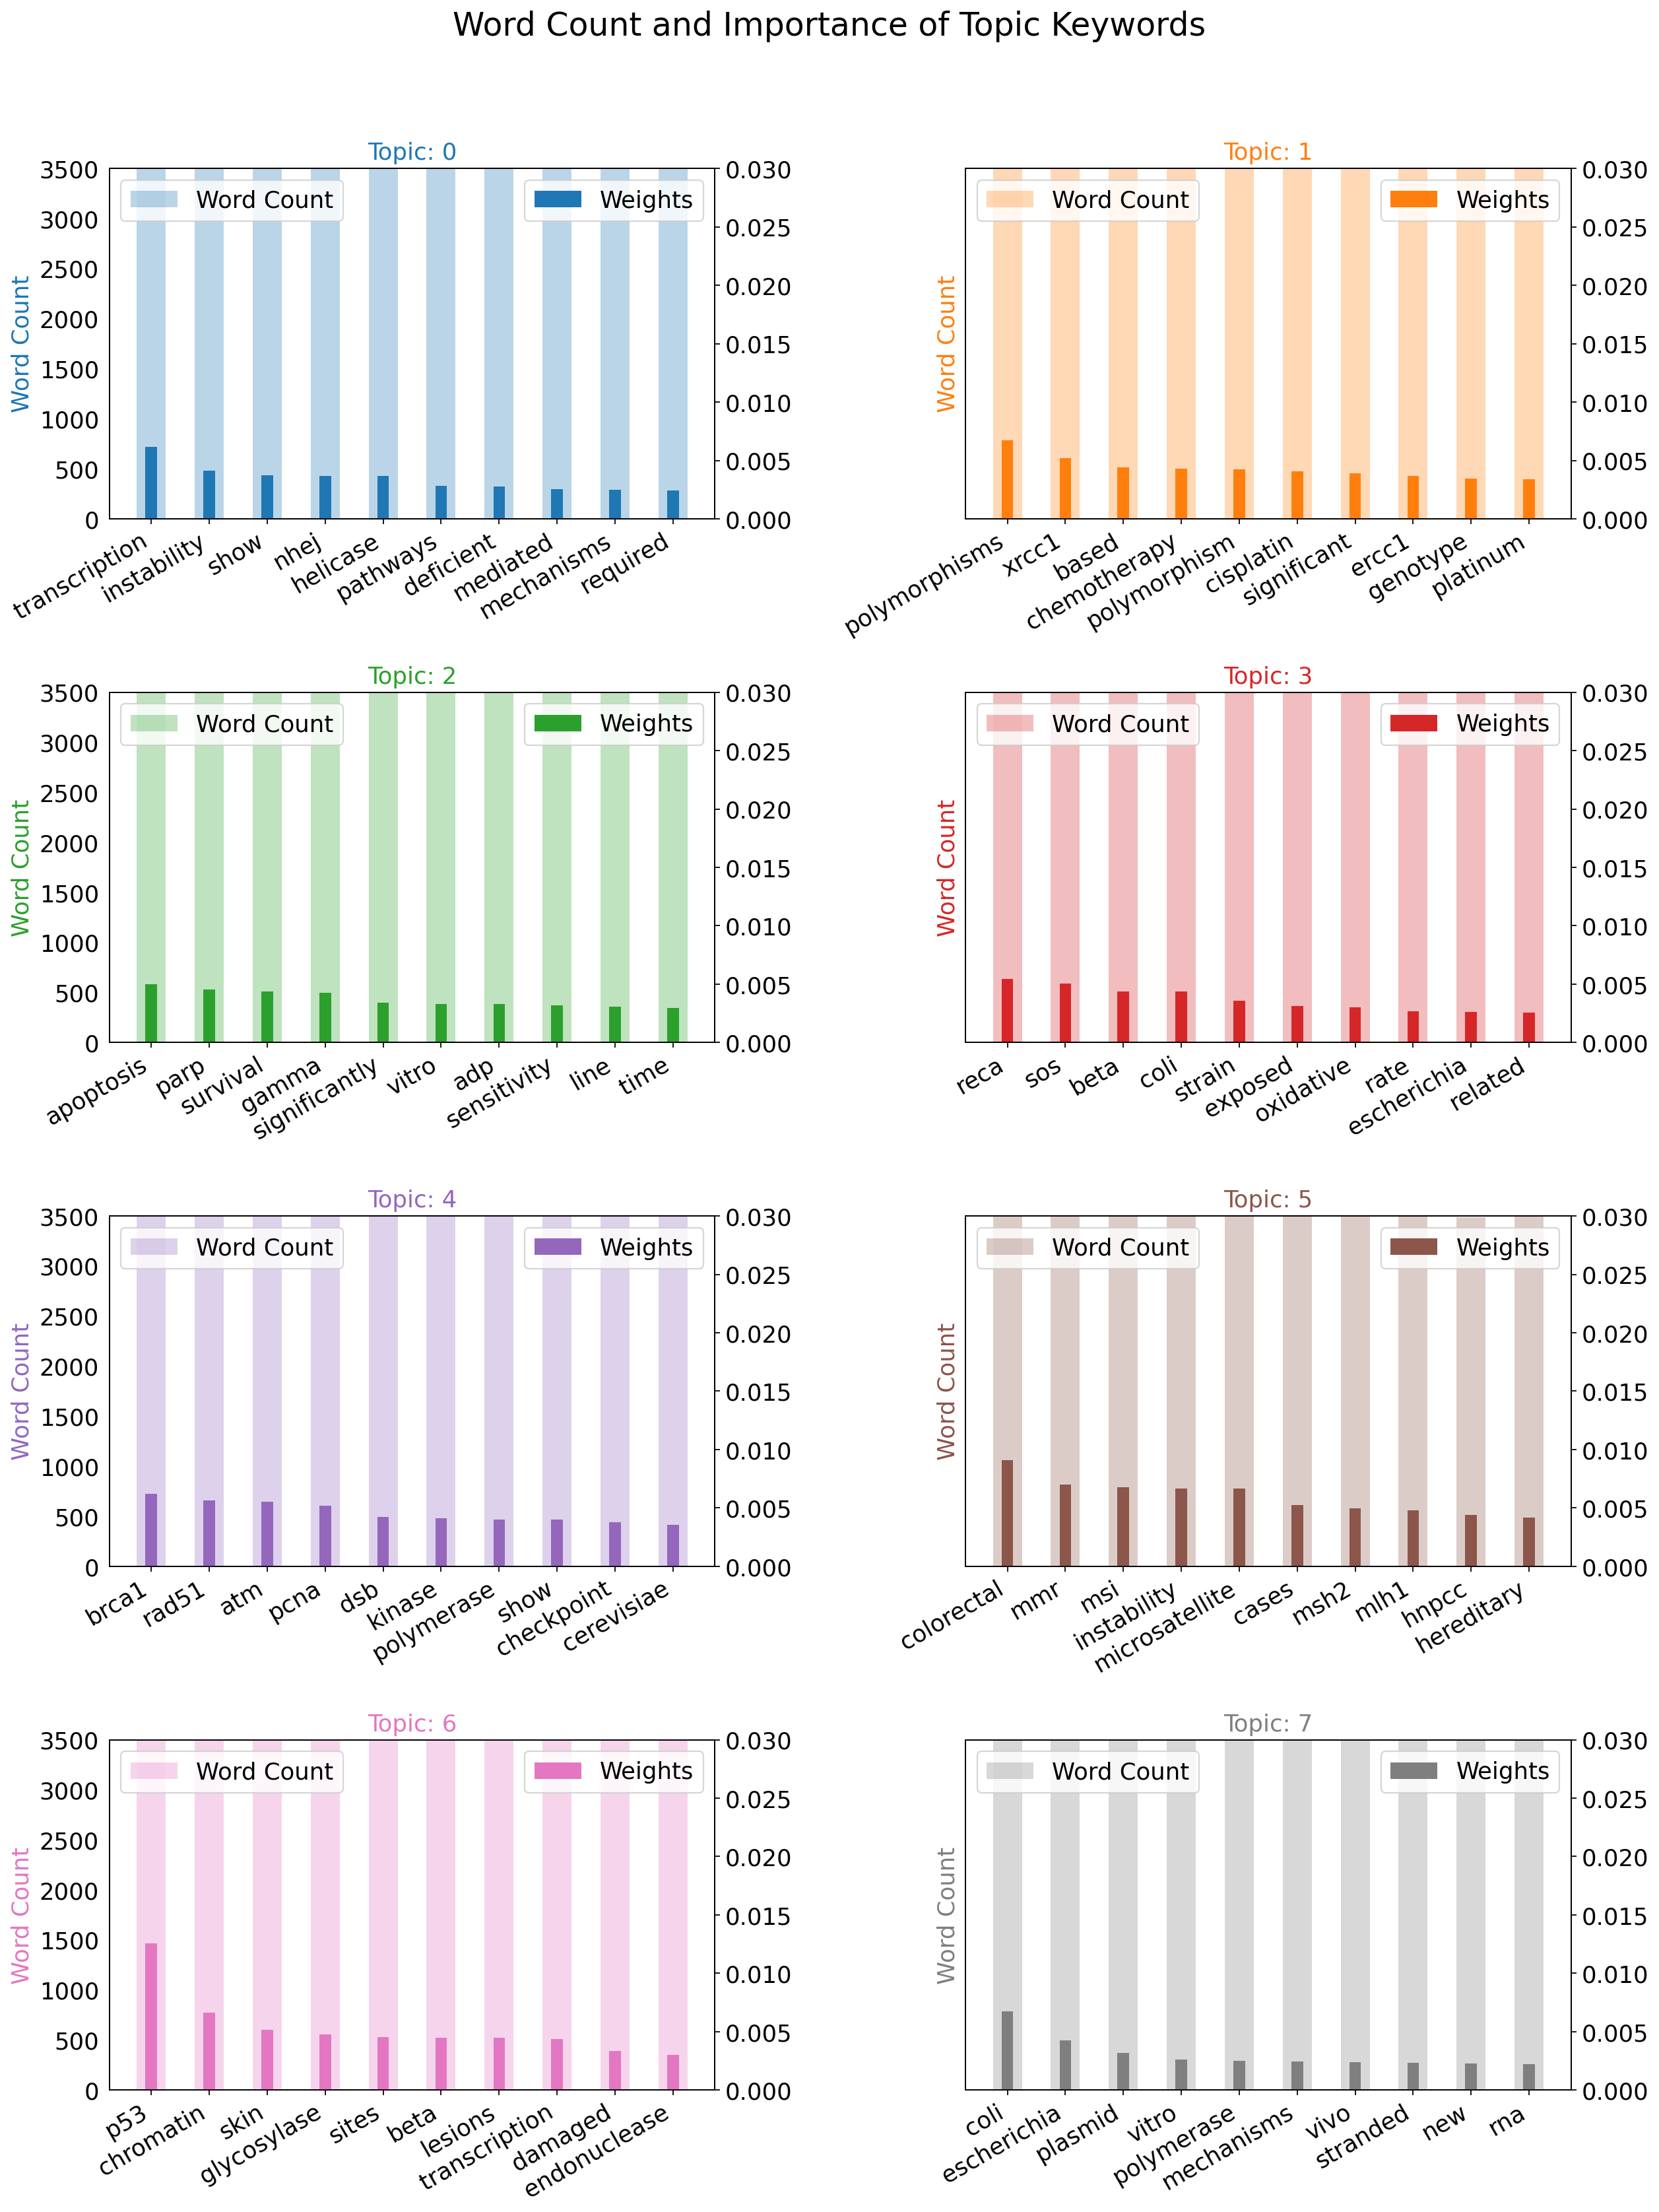

In [122]:
from collections import Counter
topics = lda_model.show_topics(formatted=False)
data_flat = [w for w_list in tokens for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        

# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(4, 2, figsize=(16,20), sharey=True, dpi=80)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    ax_twin.set_ylim(0, 0.030); ax.set_ylim(0, 3500)
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

fig.tight_layout(w_pad=2)    
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)    
plt.show()

### Sentence Chart Colored by Topic

TypeError: ignored

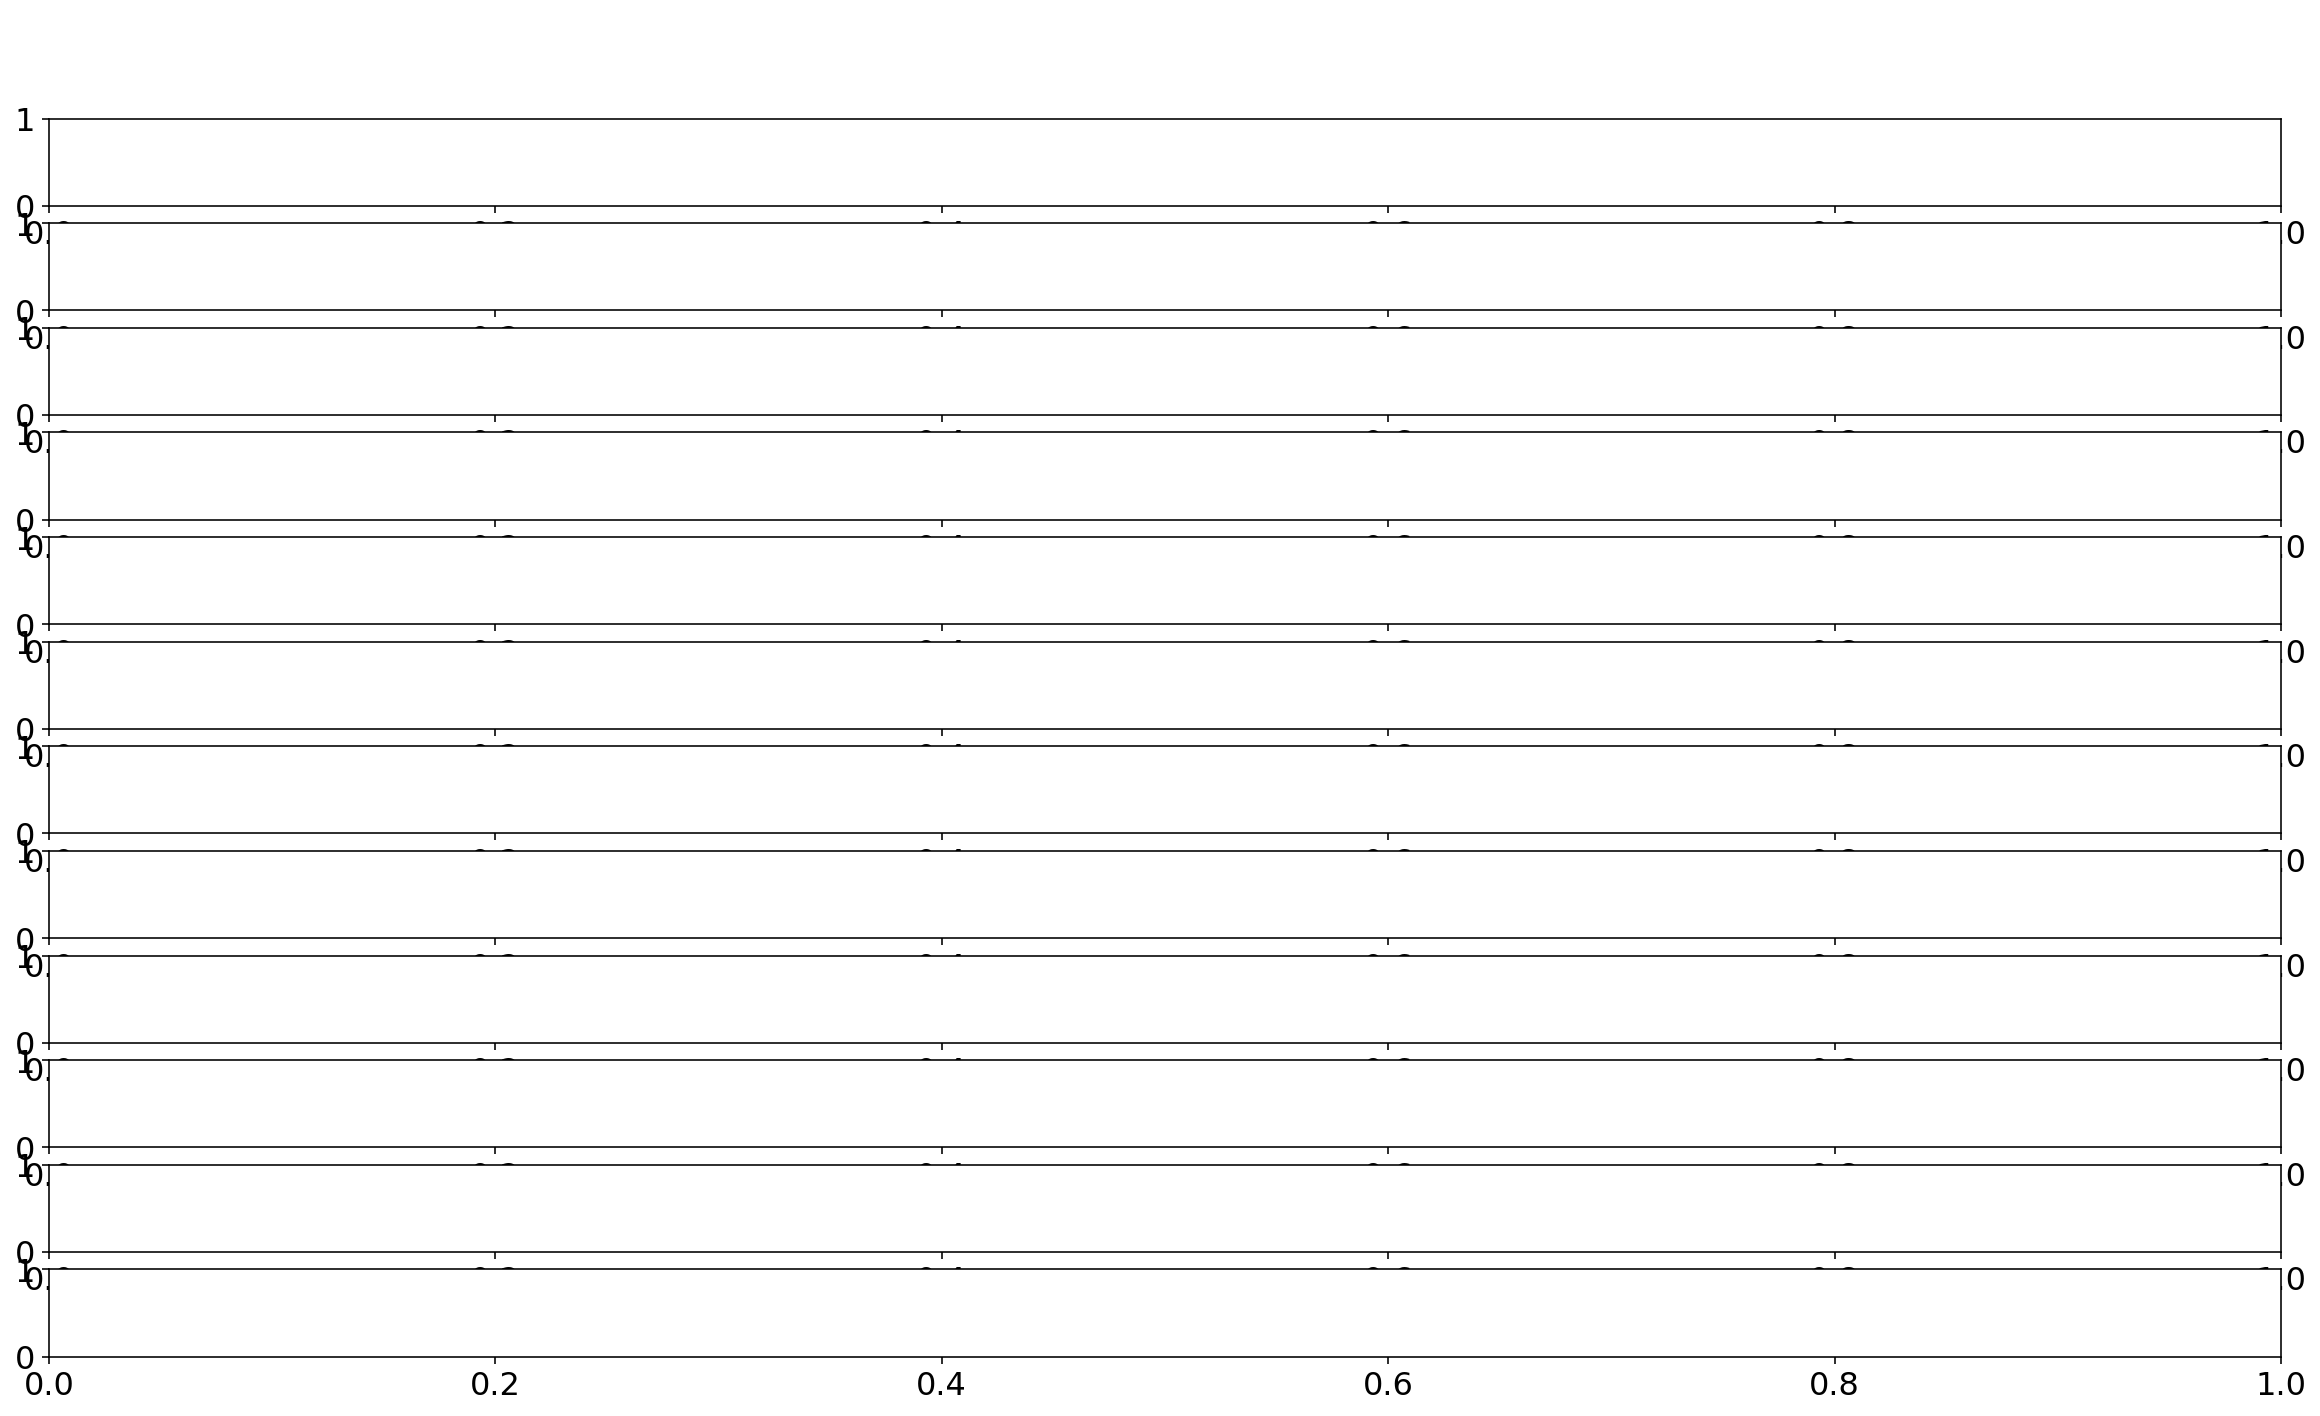

In [133]:
# Sentence Coloring of N Sentences
from matplotlib.patches import Rectangle

def sentences_chart(lda_model=lda_model, corpus=corpus, start = 0, end = 13):
    corp = corpus[start:end]
    mycolors = [color for name, color in mcolors.TABLEAU_COLORS.items()]

    fig, axes = plt.subplots(end-start, 1, figsize=(20, (end-start)*0.95))       
    axes[0].axis('off')
    for i, ax in enumerate(axes):
      if i > 0:
        corp_cur = corp[i-1] 
        topic_percs, wordid_topics, wordid_phivalues = lda_model[corp_cur]
        word_dominanttopic = [(lda_model.id2word[wd], topic[0]) for wd, topic in wordid_topics]    
        ax.text(0.01, 0.5, "Doc " + str(i-1) + ": ", verticalalignment='center',
        fontsize=16, color='black', transform=ax.transAxes, fontweight=700)

        # Draw Rectange
        topic_percs_sorted = sorted(topic_percs, key=lambda x: (x[1]), reverse=True)
        ax.add_patch(Rectangle((0.0, 0.05), 0.99, 0.90, fill=None, alpha=1, color=mycolors[topic_percs_sorted[0][0]], linewidth=2))

        word_pos = 0.06
        for j, (word, topics) in enumerate(word_dominanttopic):
          if j < 14:
            ax.text(word_pos, 0.5, word,horizontalalignment='left',
                    verticalalignment='center',
                    fontsize=16, color=mycolors[topics],
                    transform=ax.transAxes, fontweight=700)
            word_pos += .009 * len(word)  # to move the word for the next iter
            ax.axis('off')
            ax.text(word_pos, 0.5, '. . .',
                    horizontalalignment='left',
                    verticalalignment='center',
                    fontsize=16, color='black',
                    transform=ax.transAxes)       

    plt.subplots_adjust(wspace=0, hspace=0)
    plt.suptitle('Sentence Topic Coloring for Documents: ' + str(start) + ' to ' + str(end-2), fontsize=22, y=0.95, fontweight=700)
    plt.tight_layout()
    plt.show()

sentences_chart()    




In [130]:
word_dominanttopic = [(lda_model.id2word[wd], topic[0]) for wd, topic in wordid_topics] 

NameError: ignored

In [45]:
# Visualize the topics
pyLDAvis.enable_notebook()
LDAvis_data_filepath = join('./results/ldavis_prepared_'+str(num_topics))
# # this is a bit time consuming - make the if statement True
# # if you want to execute visualization prep yourself
if 1 == 1:
    LDAvis_prepared = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
    with open(LDAvis_data_filepath, 'wb') as f:
        pickle.dump(LDAvis_prepared, f)
# load the pre-prepared pyLDAvis data from disk
with open(LDAvis_data_filepath, 'rb') as f:
    LDAvis_prepared = pickle.load(f)
pyLDAvis.save_html(LDAvis_prepared, '/content/drive/MyDrive/models'+ str(num_topics) +'.html')
LDAvis_prepared

FileNotFoundError: ignored